In [1]:
!pip install -Uqq fastcore accelerate transformers diffusers

In [2]:
from transformers import CLIPTextModel, CLIPTokenizer
import torch
import numpy as np
from fastcore.all import *

We want to see the shape & structure of the mapper matrices, and don't care about details. So set `precision=1`.

In [3]:
np.set_printoptions(precision=1, linewidth=140)
torch.set_printoptions(precision=1, linewidth=140, sci_mode=False)

In [4]:
tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-large-patch14', torch_dtype=torch.float16)

In [5]:
max_len = 10

In [6]:
def get_word_inds(text: str, word_place: int, tokenizer):
    split_text = text.split(" ")
    if type(word_place) is str: word_place = [i for i, word in enumerate(split_text) if word_place == word]
    elif type(word_place) is int: word_place = [word_place]
    out = []
    if len(word_place) > 0:
        words_encode = [tokenizer.decode([item]).strip("#") for item in tokenizer.encode(text)][1:-1]
        cur_len, ptr = 0, 0

        for i in range(len(words_encode)):
            cur_len += len(words_encode[i])
            if ptr in word_place: out.append(i + 1)
            if cur_len >= len(split_text[ptr]):
                ptr += 1
                cur_len = 0
    return np.array(out)

In [7]:
def get_replacement_mapper(x: str, y: str, tokenizer=tokenizer, max_len=max_len):
    """Mapper by Weifei Chen"""
    words_x,words_y = x.split(' '), y.split(' ')
    if len(words_x) != len(words_y): raise ValueError(f"Prompts need same lengths, but are {len(words_x)} and {len(words_y)} words.")
    inds_replace = [i for i in range(len(words_y)) if words_y[i] != words_x[i]]
    inds_source = [get_word_inds(x, i, tokenizer) for i in inds_replace]
    inds_target = [get_word_inds(y, i, tokenizer) for i in inds_replace]
    mapper = np.zeros((max_len, max_len))
    i = j = 0
    cur_inds = 0
    while i < max_len and j < max_len:
        if cur_inds < len(inds_source) and inds_source[cur_inds][0] == i:
            inds_source_, inds_target_ = inds_source[cur_inds], inds_target[cur_inds]
            if len(inds_source_) == len(inds_target_):
                mapper[inds_source_, inds_target_] = 1
            else:
                ratio = 1 / len(inds_target_)
                for i_t in inds_target_: mapper[inds_source_, i_t] = ratio                
            cur_inds += 1
            i += len(inds_source_)
            j += len(inds_target_)
        elif cur_inds < len(inds_source):
            mapper[i, j] = 1
            i += 1
            j += 1
        else:
            mapper[j, j] = 1
            i += 1
            j += 1
    return torch.from_numpy(mapper).float()

In [8]:
ba_dog = 'a big ass pink dog'
ba_bts = 'a big ass grey blastoise'

In [9]:
get_replacement_mapper(ba_dog, ba_bts).shape

torch.Size([10, 10])

In [10]:
get_replacement_mapper(ba_dog, ba_bts)

tensor([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.3, 0.3, 0.3, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])

I think the code above can be simplified. Let's try.

In [11]:
my_words_x,my_words_y = ba_dog.split(' '), ba_bts.split(' ')
assert len(my_words_x)==len(my_words_y)

idxs_rpc = [i for i in range(len(my_words_y)) if my_words_y[i] != my_words_x[i]]
idxs_src = [get_word_inds(ba_dog, i, tokenizer) for i in idxs_rpc]
idxs_tgt = [get_word_inds(ba_bts, i, tokenizer) for i in idxs_rpc]

In [12]:
idxs_rpc, idxs_src, idxs_tgt

([3, 4], [array([4]), array([5])], [array([4]), array([5, 6, 7])])

In [13]:
my_mapper = torch.zeros(max_len, max_len)

In [14]:
first_change = idxs_src[0][0]
first_change

4

Before the first change, the indices are already aligned, so their map is just the identitiy matrix.

In [15]:
my_mapper[:first_change,:first_change] = torch.eye(first_change)
my_mapper[:first_change,:first_change]

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])

In [16]:
my_mapper

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

First word to change:

In [17]:
my_i_src,my_i_tgt = idxs_src[0],idxs_tgt[0]
my_i_src,my_i_tgt

(array([4]), array([4]))

In [18]:
1/len(my_i_tgt), my_mapper[my_i_src,my_i_tgt]

(1.0, tensor([0.]))

In [19]:
my_mapper[my_i_src,my_i_tgt] = 1/len(my_i_tgt)
my_mapper[my_i_src,my_i_tgt]

tensor([1.])

In [20]:
my_mapper

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

Second word to change:

In [21]:
my_i_src,my_i_tgt = idxs_src[1],idxs_tgt[1]
my_i_src,my_i_tgt

(array([5]), array([5, 6, 7]))

In [22]:
1/len(my_i_tgt), my_mapper[my_i_src,my_i_tgt]

(0.3333333333333333, tensor([0., 0., 0.]))

In [23]:
my_mapper[my_i_src,my_i_tgt] = 1/len(my_i_tgt)
my_mapper[my_i_src,my_i_tgt]

tensor([0.3, 0.3, 0.3])

In [24]:
my_mapper

tensor([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.3, 0.3, 0.3, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])

After last changes:

In [25]:
idxs_src[-1][-1], idxs_tgt[-1][-1]

(5, 7)

In [26]:
last_change = max(idxs_src[-1][-1], idxs_tgt[-1][-1])
last_change

7

In [27]:
my_mapper[last_change+1:,last_change+1:] = torch.eye(max_len-last_change-1)

In [28]:
my_mapper

tensor([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.3, 0.3, 0.3, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])

In [29]:
def get_mapper(x,y,tokenizer=tokenizer,max_len=max_len):
    """Mapper by Umer Adil"""
    words_x,words_y = x.split(' '), y.split(' ')
    assert len(words_x)==len(words_y)
    
    idxs_rpc = [i for i in range(len(words_y)) if words_y[i] != words_x[i]]
    idxs_src = [get_word_inds(x, i, tokenizer) for i in idxs_rpc]
    idxs_tgt = [get_word_inds(y, i, tokenizer) for i in idxs_rpc]

    mapper = torch.zeros(max_len, max_len)

    # Before first change
    first_change = idxs_src[0][0]
    mapper[:first_change,:first_change] = torch.eye(first_change)
    
    # Do changes
    for c in range(len(idxs_rpc)):
        idxs_src_,idxs_tgt_ = idxs_src[c],idxs_tgt[c]
        mapper[idxs_src_,idxs_tgt_] = 1/len(idxs_tgt_)

    # After last change
    last_change = max(idxs_src[-1][-1], idxs_tgt[-1][-1])
    mapper[last_change+1:,last_change+1:] = torch.eye(max_len-last_change-1)

    return mapper

In [30]:
test_eq(get_replacement_mapper(ba_dog, ba_bts),get_mapper(ba_dog,ba_bts))

In [31]:
test_cases = [
    ('a bird','a dog'),
    ('some dog','some blastoise'),
    ('ferocious turtle','sad turtle'),
]

In [32]:
max_x,max_y=0,0
for x,y in test_cases:
    max_x = max(max_x,len(tokenizer(x).input_ids))
    max_y = max(max_y,len(tokenizer(y).input_ids))
print(max_x,max_y)

5 6


Testing if the mappers are equal with
```
for x,y in test_cases:
    print(f'Testing: {x} & {y}')
    test_eq(get_replacement_mapper(x,y,max_len=7),get_mapper(x,y,max_len=7))
```
shows, that the first 2 tests pass, but for the third one we get

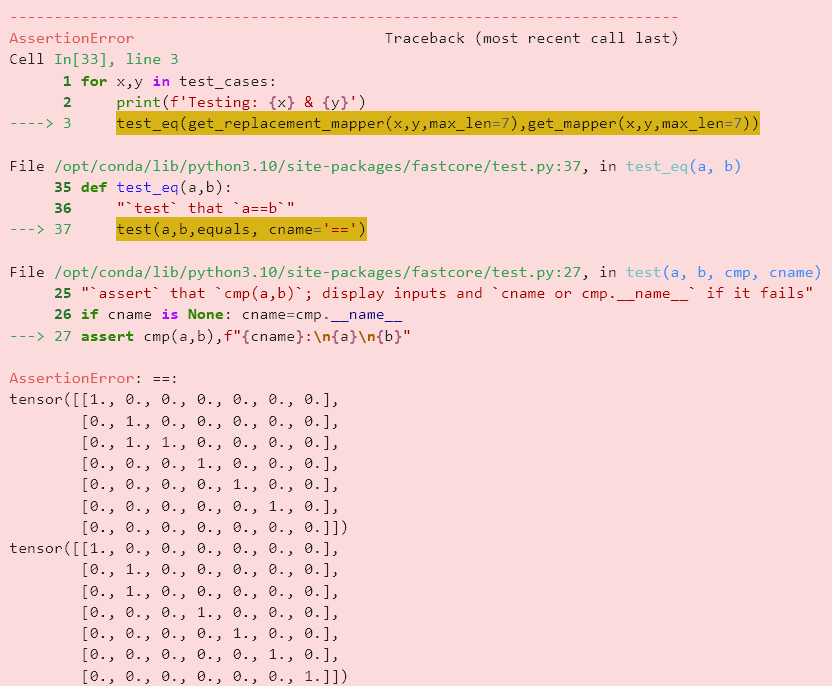

In [34]:
def do_tok(o): return tokenizer(o).input_ids
def undo_tok(o): return [tokenizer.decode(t) for t in o]

In [35]:
print(do_tok('ferocious turtle'))
print(do_tok('sad turtle'))

[49406, 45652, 879, 10912, 49407]
[49406, 3719, 10912, 49407]


In [36]:
print(undo_tok(do_tok('ferocious turtle')))
print(undo_tok(do_tok('sad turtle')))

['<|startoftext|>', 'feroci', 'ous', 'turtle', '<|endoftext|>']
['<|startoftext|>', 'sad', 'turtle', '<|endoftext|>']


We don't care about the start and finish token for now

In [37]:
get_replacement_mapper(x,y,max_len=5)[1:-1,1:-1]

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [0., 0., 1.]])

In [38]:
get_mapper(x,y,max_len=5)[1:-1,1:-1]

tensor([[1., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.]])

Q: How should mapper look like for `['feroci', 'ous', 'turtle']` and `['sad', 'turtle']`?